(sec:reg)=
# Régularisation

Comme nous l'avons vu dans les chapitres précédents, l'une des forces des réseaux neuronaux est qu'ils peuvent approximer n'importe quelle fonction continue lorsqu'un nombre suffisant de paramètres est utilisé.
Lors de l'utilisation d'approximateurs universels dans des contextes d'apprentissage automatique, un risque connexe important est celui du surajustement (_overfitting_) aux données d'apprentissage.
Plus formellement, étant donné un jeu de données d'apprentissage $\mathcal{D}_t$ tiré d'une distribution inconnue $\mathcal{D}$, les paramètres du modèle sont optimisés de manière à minimiser le risque empirique :

$$
  \mathcal{R}_e(\theta) = \frac{1}{|\mathcal{D}_t|} \sum_{(x_i, y_i) \in \mathcal{D}_t} \mathcal{L}(x_i, y_i ; m_\theta)
$$

alors que le véritable objectif est de minimiser le "vrai" risque :

$$
  \mathcal{R}(\theta) = \mathbb{E}_{x, y \sim \mathcal{D}} \mathcal{L}(x, y; m_\theta)
$$

et les deux objectifs n'ont pas le même minimiseur.

Pour éviter cet écueil, il faut utiliser des techniques de régularisation, telles que celles présentées ci-après.

## _Early stopping_

Comme illustré ci-dessous, on peut observer que l'entraînement d'un réseau neuronal pendant un trop grand nombre d'_epochs_ peut conduire à un surajustement.
Notez qu'ici, le risque réel est estimé grâce à l'utilisation d'un ensemble de validation qui n'est pas vu pendant l'entraînement.

In [1]:
import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import matplotlib.pyplot as plt
from notebook_utils import prepare_notebook_graphics
import keras_core as keras
from keras.utils import to_categorical
from myst_nb import glue
prepare_notebook_graphics()

Using TensorFlow backend


2023-08-21 14:54:04.512438: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 14:54:04.577127: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-21 14:54:04.578656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-08-21 14:54:05.888021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
iris = pd.read_csv("../data/iris.csv", index_col=0)
iris = iris.sample(frac=1)
y = to_categorical(iris["target"])
X = iris.drop(columns=["target"])
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [3]:
import keras_core as keras
from keras.layers import Dense, InputLayer
from keras.models import Sequential
from keras.utils import set_random_seed


set_random_seed(0)
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=3, activation="softmax")
])

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_split=0.3, epochs=n_epochs, batch_size=30, verbose=0)

21

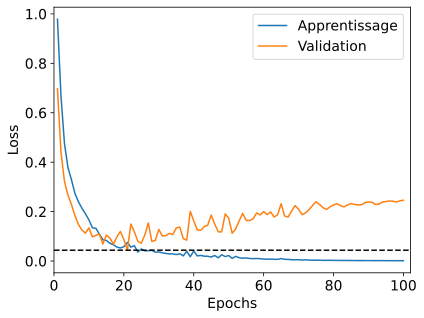

In [4]:
plt.plot(np.arange(1, n_epochs + 1), h.history["loss"], label="Apprentissage")
plt.plot(np.arange(1, n_epochs + 1), h.history["val_loss"], label="Validation")
plt.axhline(y=np.min(h.history["val_loss"]), color="k", linestyle="dashed")
plt.xlim([0, 102])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

glue("epoch_best_model", np.argmin(h.history["val_loss"]) + 1, display=False)

Ici, le meilleur modèle (en termes de capacités de généralisation) semble être le modèle à l'_epoch_ {glue:}`epoch_best_model`.
En d'autres termes, si nous avions arrêté le processus d'apprentissage après l'_epoch_ {glue:}`epoch_best_model`, nous aurions obtenu un meilleur modèle que si nous utilisons le modèle entraîné pendant 70 _epochs_.

C'est toute l'idée derrière la stratégie d'_early stopping_, qui consiste à arrêter le processus d'apprentissage dès que la perte de validation cesse de s'améliorer.
Cependant, comme on peut le voir dans la visualisation ci-dessus, la perte de validation a tendance à osciller, et on attend souvent plusieurs _epochs_ avant de supposer que la perte a peu de chances de s'améliorer dans le futur.
Le nombre d'_epochs_ à attendre est appelé le paramètre de _patience_.

Dans `keras`, l'arrêt anticipé peut être configuré via un _callback_, comme dans l'exemple suivant :

In [5]:
from keras.callbacks import EarlyStopping


set_random_seed(0)
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=256, activation="relu"),
    Dense(units=3, activation="softmax")
])

cb_es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, 
              validation_split=0.3, epochs=n_epochs, batch_size=30, 
              verbose=0, callbacks=[cb_es])

21

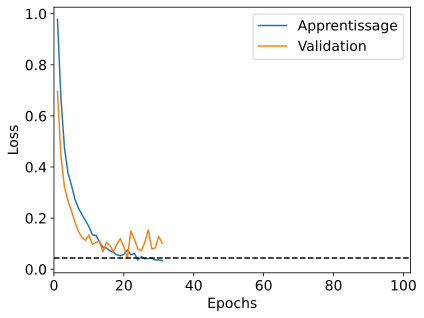

In [6]:
plt.plot(np.arange(1, len(h.history["loss"]) + 1), h.history["loss"], label="Apprentissage")
plt.plot(np.arange(1, len(h.history["val_loss"]) + 1), h.history["val_loss"], label="Validation")
plt.axhline(y=np.min(h.history["val_loss"]), color="k", linestyle="dashed")
plt.xlim([0, 102])
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

glue("epoch_best_model_es", np.argmin(h.history["val_loss"]) + 1, display=False)

Et maintenant, même si le modèle était prévu pour être entraîné pendant 70 _epochs_, l'entraînement est arrêté dès qu'il atteint 10 _epochs_ consécutives sans amélioration de la perte de validation, et les paramètres du modèle sont restaurés comme les paramètres du modèle à l'_epoch_ {glue:}`epoch_best_model_es`.


## Pénalisation de la perte

Une autre façon importante d'appliquer la régularisation dans les réseaux neuronaux est la pénalisation des pertes.
Un exemple typique de cette stratégie de régularisation est la régularisation L2.
Si nous désignons par $\mathcal{L}_r$ la perte régularisée par L2, elle peut être exprimée comme suit :

$$
  \mathcal{L}_r(\mathcal{D} ; m_\theta) = \mathcal{L}(\mathcal{D} ; m_\theta) + \lambda \sum_{\ell} \| \theta^{(\ell)} \|_2^2
$$

où $\theta^{(\ell)}$ est la matrice de poids de la couche $\ell$.

Cette régularisation tend à réduire les grandes valeurs des paramètres pendant le processus d'apprentissage, ce qui est connu pour aider à améliorer la généralisation.

En `keras`, ceci est implémenté comme :

In [7]:
from keras.regularizers import L2

λ = 0.01

set_random_seed(0)
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dense(units=256, activation="relu", kernel_regularizer=L2(λ)),
    Dense(units=256, activation="relu", kernel_regularizer=L2(λ)),
    Dense(units=256, activation="relu", kernel_regularizer=L2(λ)),
    Dense(units=3, activation="softmax")
])

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_split=0.3, epochs=n_epochs, batch_size=30, verbose=0)

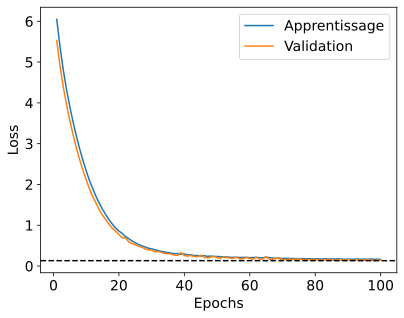

In [8]:
plt.plot(np.arange(1, len(h.history["loss"]) + 1), h.history["loss"], label="Apprentissage")
plt.plot(np.arange(1, len(h.history["val_loss"]) + 1), h.history["val_loss"], label="Validation")
plt.axhline(y=np.min(h.history["val_loss"]), color="k", linestyle="dashed")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

## _DropOut_

```{tikz} Illustration du mécanisme de _DropOut_. Afin d'entraîner un modèle donné (à gauche), à chaque _minibatch_, une proportion donnée de neurones est choisie au hasard pour être "désactivée" et le sous-réseau résultant est utilisé pour l'étape d'optimisation en cours (_cf._ figure de droite, dans laquelle 40% des neurones -- colorés en gris -- sont désactivés).
    % Model 0
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in0_model0) at  (0, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in1_model0) at  (0, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in2_model0) at  (0, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in3_model0) at  (0, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in4_model0) at  (0, 1) {};

    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_0) at  (2, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_1) at  (2, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_2) at  (2, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_3) at  (2, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model0_4) at  (2, 1) {};

    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_0) at  (4, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_1) at  (4, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_2) at  (4, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_3) at  (4, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model0_4) at  (4, 1) {};
    
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (out_0_model0) at  (6, 3) {};

    \draw[->] (in0_model0) -- (h1_model0_0);
    \draw[->] (in0_model0) -- (h1_model0_1);
    \draw[->] (in0_model0) -- (h1_model0_2);
    \draw[->] (in0_model0) -- (h1_model0_3);
    \draw[->] (in0_model0) -- (h1_model0_4);
    \draw[->] (in1_model0) -- (h1_model0_0);
    \draw[->] (in1_model0) -- (h1_model0_1);
    \draw[->] (in1_model0) -- (h1_model0_2);
    \draw[->] (in1_model0) -- (h1_model0_3);
    \draw[->] (in1_model0) -- (h1_model0_4);
    \draw[->] (in2_model0) -- (h1_model0_0);
    \draw[->] (in2_model0) -- (h1_model0_1);
    \draw[->] (in2_model0) -- (h1_model0_2);
    \draw[->] (in2_model0) -- (h1_model0_3);
    \draw[->] (in2_model0) -- (h1_model0_4);
    \draw[->] (in3_model0) -- (h1_model0_0);
    \draw[->] (in3_model0) -- (h1_model0_1);
    \draw[->] (in3_model0) -- (h1_model0_2);
    \draw[->] (in3_model0) -- (h1_model0_3);
    \draw[->] (in3_model0) -- (h1_model0_4);
    \draw[->] (in4_model0) -- (h1_model0_0);
    \draw[->] (in4_model0) -- (h1_model0_1);
    \draw[->] (in4_model0) -- (h1_model0_2);
    \draw[->] (in4_model0) -- (h1_model0_3);
    \draw[->] (in4_model0) -- (h1_model0_4);

    \draw[->] (h1_model0_0) -- (h2_model0_0);
    \draw[->] (h1_model0_0) -- (h2_model0_1);
    \draw[->] (h1_model0_0) -- (h2_model0_2);
    \draw[->] (h1_model0_0) -- (h2_model0_3);
    \draw[->] (h1_model0_0) -- (h2_model0_4);
    \draw[->] (h1_model0_1) -- (h2_model0_0);
    \draw[->] (h1_model0_1) -- (h2_model0_1);
    \draw[->] (h1_model0_1) -- (h2_model0_2);
    \draw[->] (h1_model0_1) -- (h2_model0_3);
    \draw[->] (h1_model0_1) -- (h2_model0_4);
    \draw[->] (h1_model0_2) -- (h2_model0_0);
    \draw[->] (h1_model0_2) -- (h2_model0_1);
    \draw[->] (h1_model0_2) -- (h2_model0_2);
    \draw[->] (h1_model0_2) -- (h2_model0_3);
    \draw[->] (h1_model0_2) -- (h2_model0_4);
    \draw[->] (h1_model0_3) -- (h2_model0_0);
    \draw[->] (h1_model0_3) -- (h2_model0_1);
    \draw[->] (h1_model0_3) -- (h2_model0_2);
    \draw[->] (h1_model0_3) -- (h2_model0_3);
    \draw[->] (h1_model0_3) -- (h2_model0_4);
    \draw[->] (h1_model0_4) -- (h2_model0_0);
    \draw[->] (h1_model0_4) -- (h2_model0_1);
    \draw[->] (h1_model0_4) -- (h2_model0_2);
    \draw[->] (h1_model0_4) -- (h2_model0_3);
    \draw[->] (h1_model0_4) -- (h2_model0_4);

    \draw[->] (h2_model0_0) -- (out_0_model0);
    \draw[->] (h2_model0_1) -- (out_0_model0);
    \draw[->] (h2_model0_2) -- (out_0_model0);
    \draw[->] (h2_model0_3) -- (out_0_model0);
    \draw[->] (h2_model0_4) -- (out_0_model0);

    % Model 1
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in0_model1) at  (8, 5) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (in1_model1) at  (8, 4) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (in2_model1) at  (8, 3) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in3_model1) at  (8, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (in4_model1) at  (8, 1) {};

    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (h1_model1_0) at  (10, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model1_1) at  (10, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model1_2) at  (10, 3) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (h1_model1_3) at  (10, 2) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h1_model1_4) at  (10, 1) {};

    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model1_0) at  (12, 5) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model1_1) at  (12, 4) {};
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (h2_model1_2) at  (12, 3) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (h2_model1_3) at  (12, 2) {};
    \node[draw, circle, fill=black!20!white, minimum size=17pt,inner sep=0pt] (h2_model1_4) at  (12, 1) {};
    
    \node[draw, circle, minimum size=17pt,inner sep=0pt] (out_0_model1) at  (14, 3) {};

    \draw[->] (in0_model1) -- (h1_model1_1);
    \draw[->] (in0_model1) -- (h1_model1_2);
    \draw[->] (in0_model1) -- (h1_model1_4);
    \draw[->] (in3_model1) -- (h1_model1_1);
    \draw[->] (in3_model1) -- (h1_model1_2);
    \draw[->] (in3_model1) -- (h1_model1_4);
    \draw[->] (in4_model1) -- (h1_model1_1);
    \draw[->] (in4_model1) -- (h1_model1_2);
    \draw[->] (in4_model1) -- (h1_model1_4);

    \draw[->] (h1_model1_1) -- (h2_model1_0);
    \draw[->] (h1_model1_1) -- (h2_model1_1);
    \draw[->] (h1_model1_1) -- (h2_model1_2);
    \draw[->] (h1_model1_2) -- (h2_model1_0);
    \draw[->] (h1_model1_2) -- (h2_model1_1);
    \draw[->] (h1_model1_2) -- (h2_model1_2);
    \draw[->] (h1_model1_4) -- (h2_model1_0);
    \draw[->] (h1_model1_4) -- (h2_model1_1);
    \draw[->] (h1_model1_4) -- (h2_model1_2);

    \draw[->] (h2_model1_0) -- (out_0_model1);
    \draw[->] (h2_model1_1) -- (out_0_model1);
    \draw[->] (h2_model1_2) -- (out_0_model1);
```


Dans cette section, nous présentons la stratégie _DropOut_, qui a été introduite dans {cite}`JMLR:v15:srivastava14a`.
L'idée derrière le _DropOut_ est d'éteindre certains neurones pendant l'apprentissage.
Les neurones désactivés changent à chaque _minibatch_ de sorte que, globalement, tous les neurones sont entraînés pendant tout le processus.

Le concept est très similaire dans l'esprit à une stratégie utilisée pour l'entraînement des forêts aléatoires, qui consiste à sélectionner aléatoirement des variables candidates pour chaque division d'arbre à l'intérieur d'une forêt, ce qui est connu pour conduire à de meilleures performances de généralisation pour les forêts aléatoires.
La principale différence ici est que l'on peut non seulement désactiver les _neurones d'entrée_ mais aussi les _neurones de la couche cachée_ pendant l'apprentissage.

Dans `keras`, ceci est implémenté comme une couche, qui agit en désactivant les neurones de la couche précédente dans le réseau :

In [9]:
from keras.layers import Dropout

set_random_seed(0)
switchoff_proba = 0.3
model = Sequential([
    InputLayer(input_shape=(4, )),
    Dropout(rate=switchoff_proba),
    Dense(units=256, activation="relu"),
    Dropout(rate=switchoff_proba),
    Dense(units=256, activation="relu"),
    Dropout(rate=switchoff_proba),
    Dense(units=256, activation="relu"),
    Dropout(rate=switchoff_proba),
    Dense(units=3, activation="softmax")
])

n_epochs = 100
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
h = model.fit(X, y, validation_split=0.3, epochs=n_epochs, batch_size=30, verbose=0)

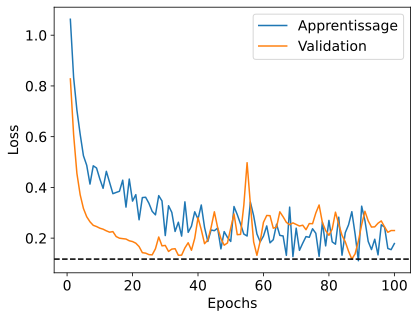

In [10]:
plt.plot(np.arange(1, len(h.history["loss"]) + 1), h.history["loss"], label="Apprentissage")
plt.plot(np.arange(1, len(h.history["val_loss"]) + 1), h.history["val_loss"], label="Validation")
plt.axhline(y=np.min(h.history["val_loss"]), color="k", linestyle="dashed")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

````{admonition} Exercice #1

En observant les valeurs de perte dans la figure ci-dessus, pouvez-vous expliquer pourquoi la perte de validation est presque systématiquement inférieure à celle calculée sur le jeu d'apprentissage ?

```{admonition} Solution
:class: dropdown, tip

En fait, la perte d'apprentissage est calculée comme la perte moyenne sur tous les _minibatchs_ d'apprentissage pendant une _epoch_.
Si nous nous rappelons que pendant l'apprentissage, à chaque _minibatch_, 30% des neurones sont désactivés, on peut voir que seule une sous-partie du modèle complet est utilisée lors de l'évaluation de la perte d'apprentissage alors que le modèle complet est utilisé lors de la prédiction sur l'ensemble de validation, ce qui explique pourquoi la perte de validation mesurée est inférieure à celle de l'apprentissage.
```
````


## Références

```{bibliography}
:filter: docname in docnames
```